In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.models import Model

## Business Understanding
- Tuberculosis (TB) is an infectious disease caused by the effect of Mycobacterium tuberculosis on the body, most specifically, the lungs. Roughly 25% of our global population is infected with Mycobacterium tuberculosis, most of whom have what is known as “latent tuberculosis.” This means that they have subclinical cases and show no signs of disease and cannot spread the infection to others. 10% of these individuals will go on to develop active TB (2.5% of the global population). “Eight countries accounted for two thirds of the new TB cases: India, China, Indonesia, the Philippines, Pakistan, Nigeria, Bangladesh and South Africa.” While the cost for initial testing can and has been reduced, the cost of follow-up imaging and interpretation remains expensive.
- Given the poverty experienced in the countries experiencing the highest TB case counts, The World Health Organization wishes to offer cheaper assessment of X-ray images obtained from patients so as to greatly aid in the reduction of active cases by allowing doctors to assess lung images more often. Given this need, a neural network that can classify X-ray images as having come from patients with TB, verus from patients without TB or with latent TB, would be extremely useful in active case reduction.

## Data Understanding
- Researchers and doctors from Qatar University, the University of Dhakaalong and Hamad Medical Corporation amassed a database of chest X-rays of TB-positive and TB-negative cases, consisting of 4,200 images. ([Link to academic paper](https://ieeexplore.ieee.org/document/9224622)) The imaging data can be accessed via [Kaggle](https://www.kaggle.com/tawsifurrahman/tuberculosis-tb-chest-xray-dataset).

- The 4,200 chest X-rays contained in this dataset will allow for the training of a neural network to assist physicians in poorer countries to assess patient tuberculosis status. With 3,500 normal X-rays and 700 tuberculosis X-rays, there is obvious class imbalance. All images are of the same size.

- In this setting, a false positive would result from the neural network identifying an x-ray from a normal patient as demonstrative of tuberculosis. Conversely, a false negative would result from the neural network identifying an x-ray from a patient with tuberculosis lesions as demonstrative of normal anatomy.

## Technical Summary
- I am aiming to maximize accuracy and recall in order to minimize false negatives (i.e., patients with tuberculosis being classified as normal). 
- My baseline model is a simple multilayer perceptron (MLP) model with one hidden layer using the tanh activation function. I used the sigmoid function as the activation function for the output layers for all models, since this is a binary classification project. Validation recall was immediately at zero for this first model (i.e., the false negative rate was at a maximum) and the model remained at zero recall for all epochs. It is apparently always predicting that a chest x-ray is "normal." This is apparent because the validation accuracy is equivalent to the percentage of images that are normal (83%).
- My second model is another multi-layer perceptron. It has one hidden layer using the relu activation function instead of the tanh activation function. This model has done far better. It is no longer predicting only one class. The validation accuracy and validation recall achieved in epoch 6 were impressive and were 92% and 90%, respectively. I will return to this model if more optimal metrics are not acheived.
- My third model is yet another multi-layer perceptron with a one hidden layer (relu activation function used again) and dropout layer(25%). The model demonstrated the same issue as the first model. It is apparently always predicting that a chest x-ray is "normal." This is apparent because the validation accuracy is equivalent to the percentage of images that are normal (83%).
- My fourth model is once again a multi-layer perceptron, with two hidden layers (relu activation function) and two dropout layers(25%). While this model achieved impressive validation accuracy scores above 90% and avoided overfitting, its validation recall scores were subpar and remained below 76%.
- My fifth model was a convolutional neural network with 3 pairs of double convolution layers before pooling. While this model achieved validation accuracy of 95% and validation recall of 81%, there was more overfitting seen here then in my third model which achieved scores of 91% for both metrics. As surprising as this seems the third simple multilayer perceptron appears to be the best model to classify this dataset.

## Directory Structure

In [2]:
'''

├── TB_Chest_Radiography_Database       <- Chest X-rays 
│   └── Data_split                      <- training, testing and validation sets
│       ├── Train                       <- training X-rays (70% of total X-rays)
│       │    ├── Normal                
│       │    ├── Tuberculosis 
│       ├── Test                       <- testing X-rays (20% of total X-rays)
│       │    ├── Normal                
│       │    ├── Tuberculosis 
│       └── Validation                  <- validation X-rays (10% of total X-rays)
│             ├── Normal                
│             └──Tuberculosis 

'''
print("(directory structure)")

(directory structure)


## Data Preparation
- I will prepare the data by scaling the red/green/blue contributions to each image by dividing by 255 to scale each contribution to a range between -1 and +1. 
- The training, testing and validation sets were divided and arranged locally to represent 70%, 20% and 10% of the images, respectively.

In [3]:
# Instantiating a generator object and normalizing the RGB values
traingen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
testgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
valgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_data = traingen.flow_from_directory(
    directory='TB_Chest_Radiography_Database/Data_split/Train',
    target_size=(512, 512),
    class_mode='binary',
    batch_size=20,
    seed=42
)

val_data = testgen.flow_from_directory(
    directory='TB_Chest_Radiography_Database/Data_split/Validation',
    target_size=(512, 512),
    class_mode='binary',
    batch_size=20,
    seed=42
)

test_data = valgen.flow_from_directory(
    directory='TB_Chest_Radiography_Database/Data_split/Test',
    target_size=(512, 512),
    class_mode='binary',
    batch_size=20,
    seed=42
)

Found 2940 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [4]:
# Putting image classification into a dataframe
classes = pd.DataFrame(train_data.classes)
values = classes.value_counts()

In [5]:
# Giving the data binary labels to allow for visialization of class imbalance below.
class_dict = {0:'Normal', 1:'Tuberculosis'}
classes[0] = classes[0].map(class_dict)

In [6]:
image_interpretation = classes[0].value_counts()
image_interpretation

Normal          2450
Tuberculosis     490
Name: 0, dtype: int64

In [7]:
image_interpretation.index

Index(['Normal', 'Tuberculosis'], dtype='object')

### Visualization of Class Imbalance

/Users/daniellerossman/Desktop/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


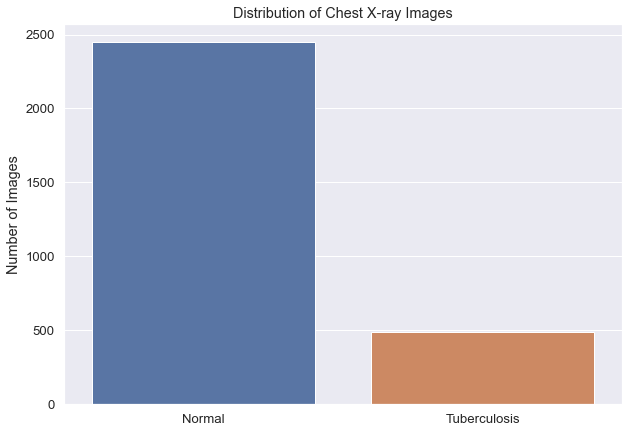

In [8]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.2)
sns.barplot(image_interpretation.index, image_interpretation.values)
plt.ylabel("Number of Images")
plt.title('Distribution of Chest X-ray Images');

### Visualization of a small sample of chest X-rays from the dataset.

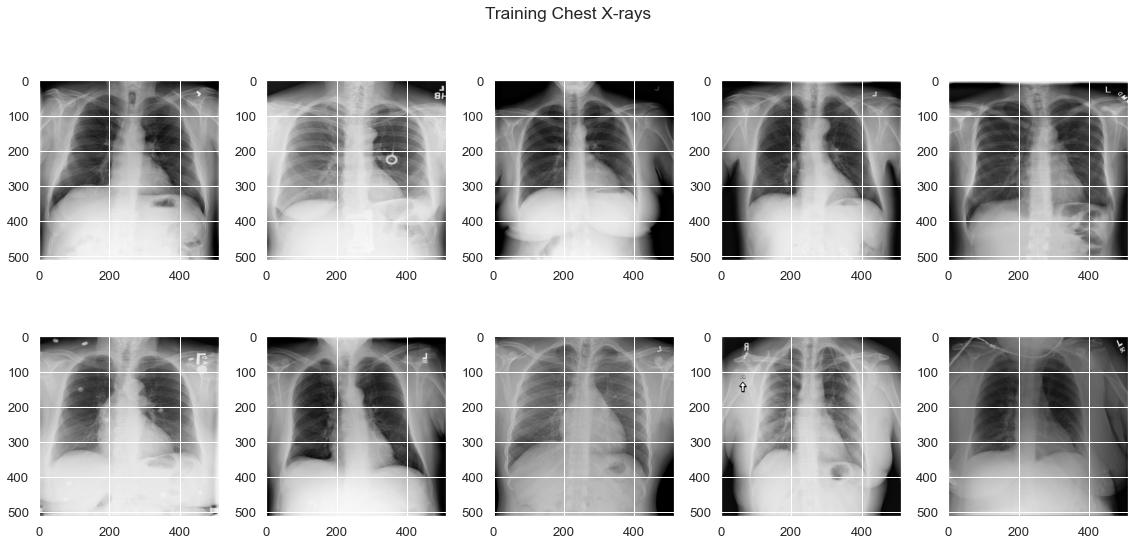

In [9]:
# Visualization of 10 CXRs.
train_batch = train_data.next()
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
    
for i in range(10):
    # Load image into numpy array and re-scale
    img = np.array(train_batch[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
fig.suptitle('Training Chest X-rays')
plt.tight_layout()
plt.show()

In [10]:
input_shape = (512,512,3)

## Multilayer Perceptron Models
- My first model is a baseline multi-layer perceptron. It has one hidden layer with one hidden layer using the tanh activation function. I used the sigmoid function as the activation function for the output layer, since this is a binary classification project. 
- I will build iterations of this to optimize both accuracy and recall. As mentioned above recall is an important metric as an indicator of minimization of false negatives.

In [11]:
# Building baseline model, a multi-layer perceptron
baseline = keras.Sequential(
    [
        keras.Input(shape=input_shape), 
        layers.Flatten(), # need to flatten our images to be one long array
        layers.Dense(100, activation="tanh"),
        layers.Dense(1, activation="sigmoid"), #sigmoid for binary classification
    ])

baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 786432)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               78643300  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 78,643,401
Trainable params: 78,643,401
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compiling
baseline.compile(optimizer="sgd", loss="binary_crossentropy",
                 metrics=['acc', 'Recall', 'Precision'])

In [13]:
#Fitting
baseline_results = baseline.fit_generator(train_data,
                              steps_per_epoch=20,
                              epochs=10,
                              validation_data=val_data)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
20/20 [==============================] - 19s 938ms/step - loss: 1.6712 - acc: 0.8400 - recall: 0.0164 - precision: 0.2000 - val_loss: 1.5915 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 18s 887ms/step - loss: 1.3015 - acc: 0.8375 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.0476 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 12s 625ms/step - loss: 0.8762 - acc: 0.8125 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.5314 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 12s 606ms/step - loss: 0.5225 - acc: 0.8050 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.4549 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/

#### Findings: First Multilayer Perceptron

- This model does not seem to be progressing. It is apparently always predicting that a chest x-ray is "normal." This is apparent because the validation accuracy is equivalent to the percentage of images that are normal (83%).

- Next Model: My second model is another multi-layer perceptron. It has one hidden layer using the relu activation function instead of the tanh activation function. 


In [14]:
# Setting up a 1st of iteration baseline MLP
baseline2 = keras.Sequential(
    [
        keras.Input(shape=(input_shape)), 
        keras.layers.Flatten(), 
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])

baseline2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 786432)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               78643300  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 78,643,401
Trainable params: 78,643,401
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compiling
baseline2.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['acc', 'Recall', 'Precision'])

In [16]:
#Fitting
baseline2_results = baseline2.fit_generator(train_data,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=val_data)

Epoch 1/10
100/100 [==============================] - 35s 354ms/step - loss: 35.2861 - acc: 0.8480 - recall: 0.5375 - precision: 0.5441 - val_loss: 10.5310 - val_acc: 0.8631 - val_recall: 0.8857 - val_precision: 0.5561
Epoch 2/10
100/100 [==============================] - 36s 356ms/step - loss: 8.9344 - acc: 0.9085 - recall: 0.7351 - precision: 0.7243 - val_loss: 10.7321 - val_acc: 0.9167 - val_recall: 0.5071 - val_precision: 0.9861
Epoch 3/10
100/100 [==============================] - 36s 357ms/step - loss: 5.0374 - acc: 0.9245 - recall: 0.7665 - precision: 0.7781 - val_loss: 2.6460 - val_acc: 0.9345 - val_recall: 0.8000 - val_precision: 0.8058
Epoch 4/10
100/100 [==============================] - 34s 339ms/step - loss: 1.5122 - acc: 0.9535 - recall: 0.8576 - precision: 0.8602 - val_loss: 3.9063 - val_acc: 0.9417 - val_recall: 0.6786 - val_precision: 0.9596
Epoch 5/10
100/100 [==============================] - 34s 341ms/step - loss: 1.9674 - acc: 0.9310 - recall: 0.7812 - precision: 0

#### Findings: Second Multilayer Perceptron
- This model has done far better. It is no longer predicting only one class. The validation accuracy and validation recall achieved in epoch 6 were impressive and were 92% and 90%, respectively. I will return to this model if more optimal metrics are not acheived.

#### Next Model: My third model is another multi-layer perceptron. It has been altered by using a dropout layer (dropout of 25%).

In [17]:
one_hidden_dropout_layer = keras.Sequential(
    [
        keras.Input(shape=(input_shape)), 
        keras.layers.Flatten(),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation="sigmoid"),
    ])

one_hidden_dropout_layer.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 786432)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               78643300  
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 78,643,401
Trainable params: 78,643,401
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling
one_hidden_dropout_layer.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['acc', 'Recall', 'Precision'])

In [19]:
# Fitting
one_hidden_dropout_layer_results = one_hidden_dropout_layer.fit_generator(train_data,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=val_data)


Epoch 1/10
100/100 [==============================] - 35s 353ms/step - loss: 30.1215 - acc: 0.8010 - recall: 0.4012 - precision: 0.4182 - val_loss: 0.3431 - val_acc: 0.8321 - val_recall: 0.0071 - val_precision: 0.3333
Epoch 2/10
100/100 [==============================] - 39s 388ms/step - loss: 0.3403 - acc: 0.8290 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3135 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 38s 377ms/step - loss: 0.3935 - acc: 0.8265 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3353 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 35s 349ms/step - loss: 0.4064 - acc: 0.8315 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3511 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 38s 384ms/step - loss: 0.4278

#### Findings: Third Multilayer Perceptron
- The model demonstrated the same issue as the first model. It is apparently always predicting that a chest x-ray is "normal." This is apparent because the validation accuracy is equivalent to the percentage of images that are normal (83%).

#### Next Model: My fourth model is yet another multi-layer perceptron. It has been altered by using 2 hidden layers (relu activation function) and two intervening dropout layers (dropout of 25%).

In [20]:
two_hidden_dropout_layers = keras.Sequential(
    [
        keras.Input(shape=(input_shape)), 
        keras.layers.Flatten(),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation="sigmoid"),
    ])

two_hidden_dropout_layers.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 786432)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78643300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 78,653,501
Trainable params: 78,653,501
Non-trainable params: 0
__________________________________________

In [21]:
# Compiling
two_hidden_dropout_layers.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['acc', 'Recall', 'Precision'])

In [22]:
# Fitting
two_hidden_dropout_layers_results = two_hidden_dropout_layers.fit_generator(train_data,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=val_data)

Epoch 1/10
100/100 [==============================] - 45s 447ms/step - loss: 21.8675 - acc: 0.7800 - recall: 0.1545 - precision: 0.2406 - val_loss: 0.3932 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 41s 406ms/step - loss: 0.5077 - acc: 0.8285 - recall: 0.0119 - precision: 0.2667 - val_loss: 0.4077 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 40s 395ms/step - loss: 0.4265 - acc: 0.8315 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.4124 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 41s 407ms/step - loss: 0.6192 - acc: 0.8330 - recall: 0.0091 - precision: 0.2500 - val_loss: 0.4663 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 41s 409ms/step - loss: 0.4648 - acc: 

#### Findings: Fourth Multilayer Perceptron
- My fourth model is once again a multi-layer perceptron, with two hidden layers (relu activation function) and two dropout layers(25%). The model demonstrated the same issue as the first model. It is apparently always predicting that a chest x-ray is "normal." This is apparent because the validation accuracy is equivalent to the percentage of images that are normal (83%).

## Convoluntional Neural Network

#### Next Model: My fifth model is connvoluntional neural network with double convolution layers before pooling.

In [ ]:
# Set up for this CNN model is from this blog:  https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
cnn = keras.Sequential()

cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))
cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))
cnn.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))


cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(128, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))


cnn.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

# Fitting
cnn_results = cnn.fit_generator(train_data,
                                steps_per_epoch=100,
                                epochs=10,
                                validation_data=val_data)


Epoch 1/10
100/100 [==============================] - 873s 9s/step - loss: 0.3862 - acc: 0.8370 - recall: 0.2456 - precision: 0.5390 - true_positives: 83.0000 - true_negatives: 1591.0000 - false_positives: 71.0000 - false_negatives: 255.0000 - val_loss: 0.1826 - val_acc: 0.9393 - val_recall: 0.6857 - val_precision: 0.9320 - val_true_positives: 96.0000 - val_true_negatives: 693.0000 - val_false_positives: 7.0000 - val_false_negatives: 44.0000
Epoch 2/10
100/100 [==============================] - 872s 9s/step - loss: 0.1485 - acc: 0.9430 - recall: 0.8023 - precision: 0.8615 - true_positives: 280.0000 - true_negatives: 1606.0000 - false_positives: 45.0000 - false_negatives: 69.0000 - val_loss: 0.1379 - val_acc: 0.9536 - val_recall: 0.7429 - val_precision: 0.9720 - val_true_positives: 104.0000 - val_true_negatives: 697.0000 - val_false_positives: 3.0000 - val_false_negatives: 36.0000
Epoch 3/10
100/100 [==============================] - 857s 9s/step - loss: 0.1450 - acc: 0.9470 - recall: 0

#### Findings: Fifth Model (Convolutional Neural Network)
My fifth model has 3 sets of double convulutional layers before pooling. While this model achieved validation accuracy of 95% and validation recall of 81%, there was more overfitting seen here then in my third model which achieved  scores of 91% for both metrics. As surprising as this seems the third simple multilayer perceptron appears to be the best model to classify this dataset.

### Testing the Final Model with the Validation Data

In [ ]:
baseline2_results = baseline2.fit_generator(train_data,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=test_data)

### Visualizing Results with a Confusion Matrix

In [ ]:
def oes_matrix(results):
    """
    Credit: 'https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb'
    
    Plots a confusion matrix using the results atrribute of a Keras history object
  
    Parameters:
    results (keras.callbacks.History): 
  
    Returns:
    None
    """
    
    conf = np.array([[results.history['true_positives'][-1], results.history['false_negatives'][-1]], [results.history['false_positives'][-1], results.history['true_negatives'][-1]]])
    fig, ax = plt.subplots(figsize=(10, 8))
    heat = sns.heatmap(conf.astype('int'), annot=True, fmt='g', ax=ax )
    heat.set_xticklabels(['Tuberculosis', 'Normal'], fontsize=15)
    heat.set_yticklabels(['Tuberculosis', 'Normal'], fontsize=15)
    plt.ylabel('True Label',fontsize=18)
    plt.xlabel('Predicted Label', fontsize=18)

## Overall Conclusions
- While altering various hyperparameters and changing the shapes and depths of these neural networks, varying levels of the key metrics (accuracy and recall) were achieved. I used the sigmoid function as the activation function for the output layers of all models, since this is a binary classification project. My second model, a simple multilayer perceptron with one hidden layer using the relu activation function, showed promise with maximum validation accuracy and validation recall both at 92% and 90%, respectively (without significant overfitting). My first, third and fourth models all always predicting that a chest x-ray was "normal." This was apparent because the validation accuracy was equivalent to the percentage of images that were normal (83%) within the dataset. My fifth model was a convolutional neural network with three sets of double convulutional layers before pooling. While this model achieved validation accuracy of 95% and validation recall of 81%, there was more overfitting seen here then in my third model which acheived a higher validation recall score. As surprising as this seems the third simple multilayer perceptron appears to be the best model to classify this dataset.
- Future steps include: testing this tool in a rural and urban area and calculating how many more cases it predicts accurately than the participating physicians, the decrease in care delay and the decrease in unecessary spread of tuberculosis in those testing regions.